Mikołaj Pacek

# Predicting house prices
The task is to predict house price. Related issue https://github.com/pbiecek/InterpretableMachineLearning2020/issues/6

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("kc_house_data.csv")
df.drop(columns=["id"], inplace=True)
df.date = pd.to_datetime(df.date)
# Extract parts of date
df["year"] = pd.DatetimeIndex(df.date).year
df["month"] = pd.DatetimeIndex(df.date).month
df["day"] = pd.DatetimeIndex(df.date).day
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'day'],
      dtype='object')

# Let's look at the data
For each columns I look at histogram of values less than 0.95 quantile, because lots of variable distributions look poisson distribution.

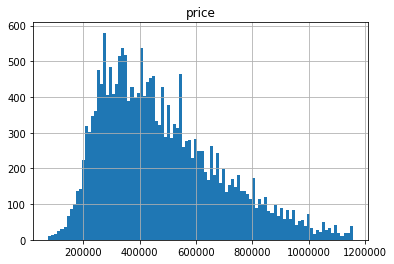

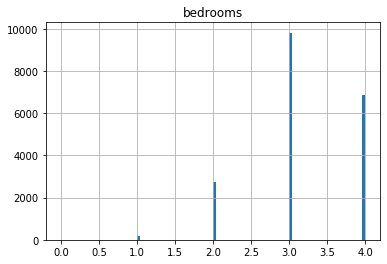

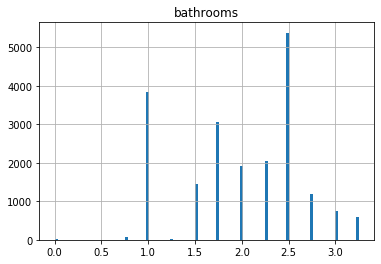

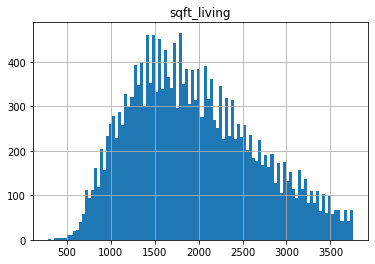

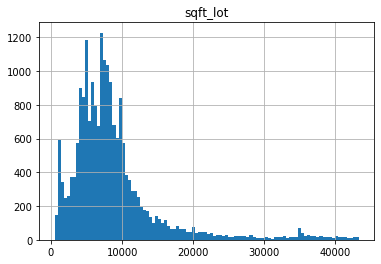

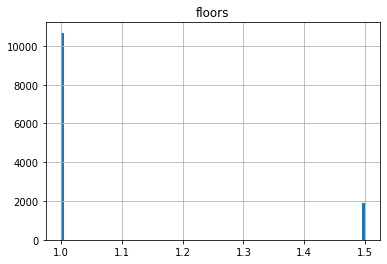

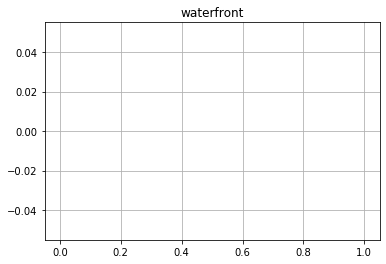

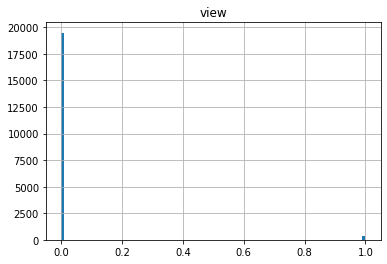

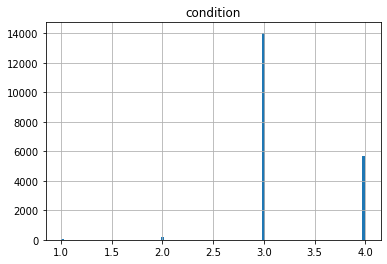

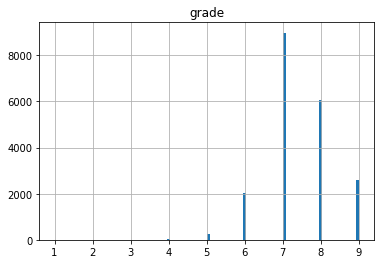

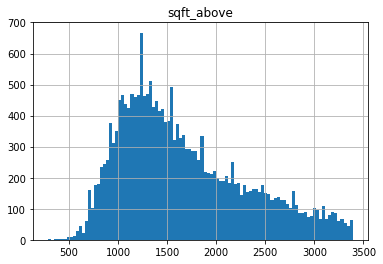

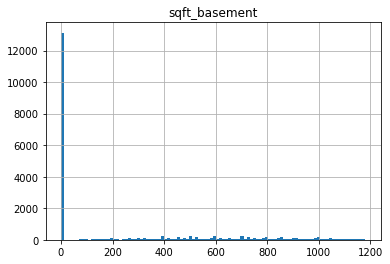

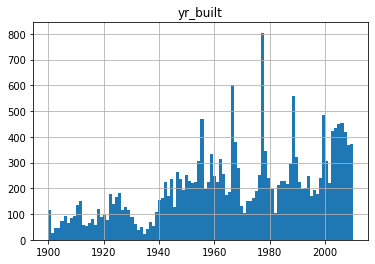

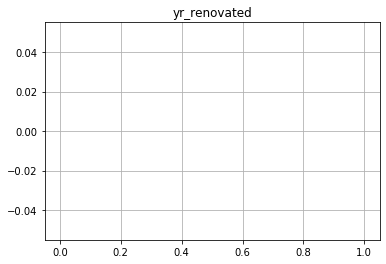

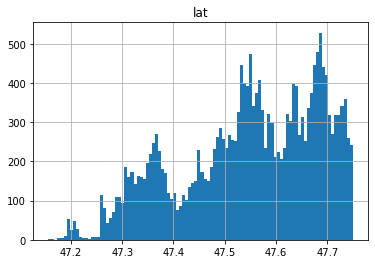

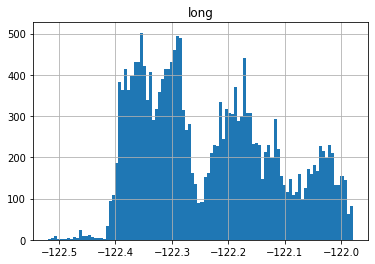

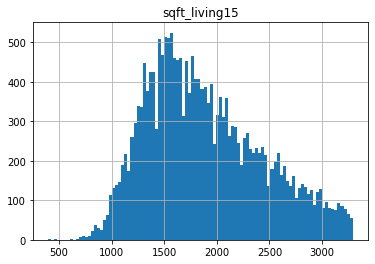

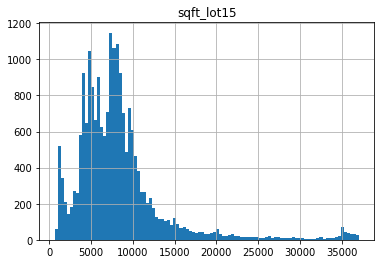

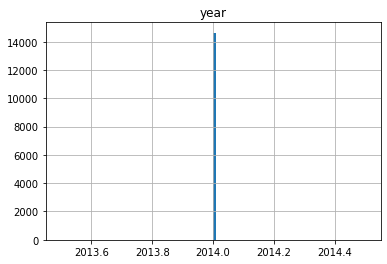

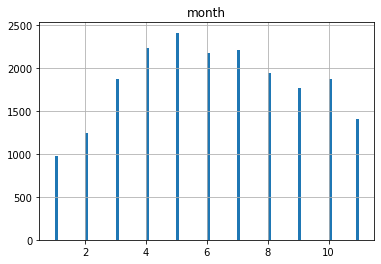

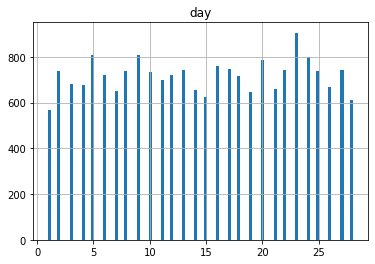

In [2]:
for c in df.drop(columns=["date", "zipcode"]).columns:
    df[df[c] < df[c].quantile(0.95)][c].hist(bins=100)
    plt.title(c)
    plt.show()

a small funny thing to notice is that we allow non-integer number of bathrooms. For example a house can have "2.5 bathrooms".

In [3]:
df.bathrooms.value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
8.00       2
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

# What correlates with price?

In [4]:
df.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
year             0.003576
month           -0.010081
day             -0.014670
zipcode         -0.053203
Name: price, dtype: float64

It is quite intuitive that the bigger and "better" the house, the higher the price. A good ML model should take advantage of this.

# Train a simple model

## Prepare data

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["price", "date"]), df["price"], train_size=0.75)

## Train

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Keep max_depth low so the tree can be printable
model = RandomForestRegressor(max_depth=3, n_estimators=1000)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Evaluate

In [7]:
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_error
import numpy as np


def print_summary(dataset, x, y):
    y_pred = model.predict(x)
    print(f"{dataset} METRICS", 
          "\nMSE", np.sqrt(mean_squared_error(y, y_pred)), 
          "\nexplained var", explained_variance_score(y, y_pred), 
          "\nmax err", max_error(y, y_pred), 
          "\nmean abs err", mean_absolute_error(y, y_pred), 
          "\nabs error as percent of mean price", round(mean_absolute_error(y, y_pred) / y.mean(), 4), 
          "\nmean relative error", round(np.mean(np.abs(y - y_pred) / y), 4), "\n")
    
print_summary("TRAIN", x_train, y_train)
print_summary("TEST", x_test, y_test)

TRAIN METRICS 
MSE 210246.74120830605 
explained var 0.6818040642975303 
max err 2739700.8586842613 
mean abs err 127121.94385512611 
abs error as percent of mean price 0.2341 
mean relative error 0.2481 

TEST METRICS 
MSE 207925.83250254614 
explained var 0.6466137476450307 
max err 3224953.6250533396 
mean abs err 124936.120623844 
abs error as percent of mean price 0.2353 
mean relative error 0.2506 



This simple model has a relative error of 25%, which is ok, but if we set max_depth to a higher value we can achieve a lower error. However tall trees are difficult to visualize

# Visualize one tree

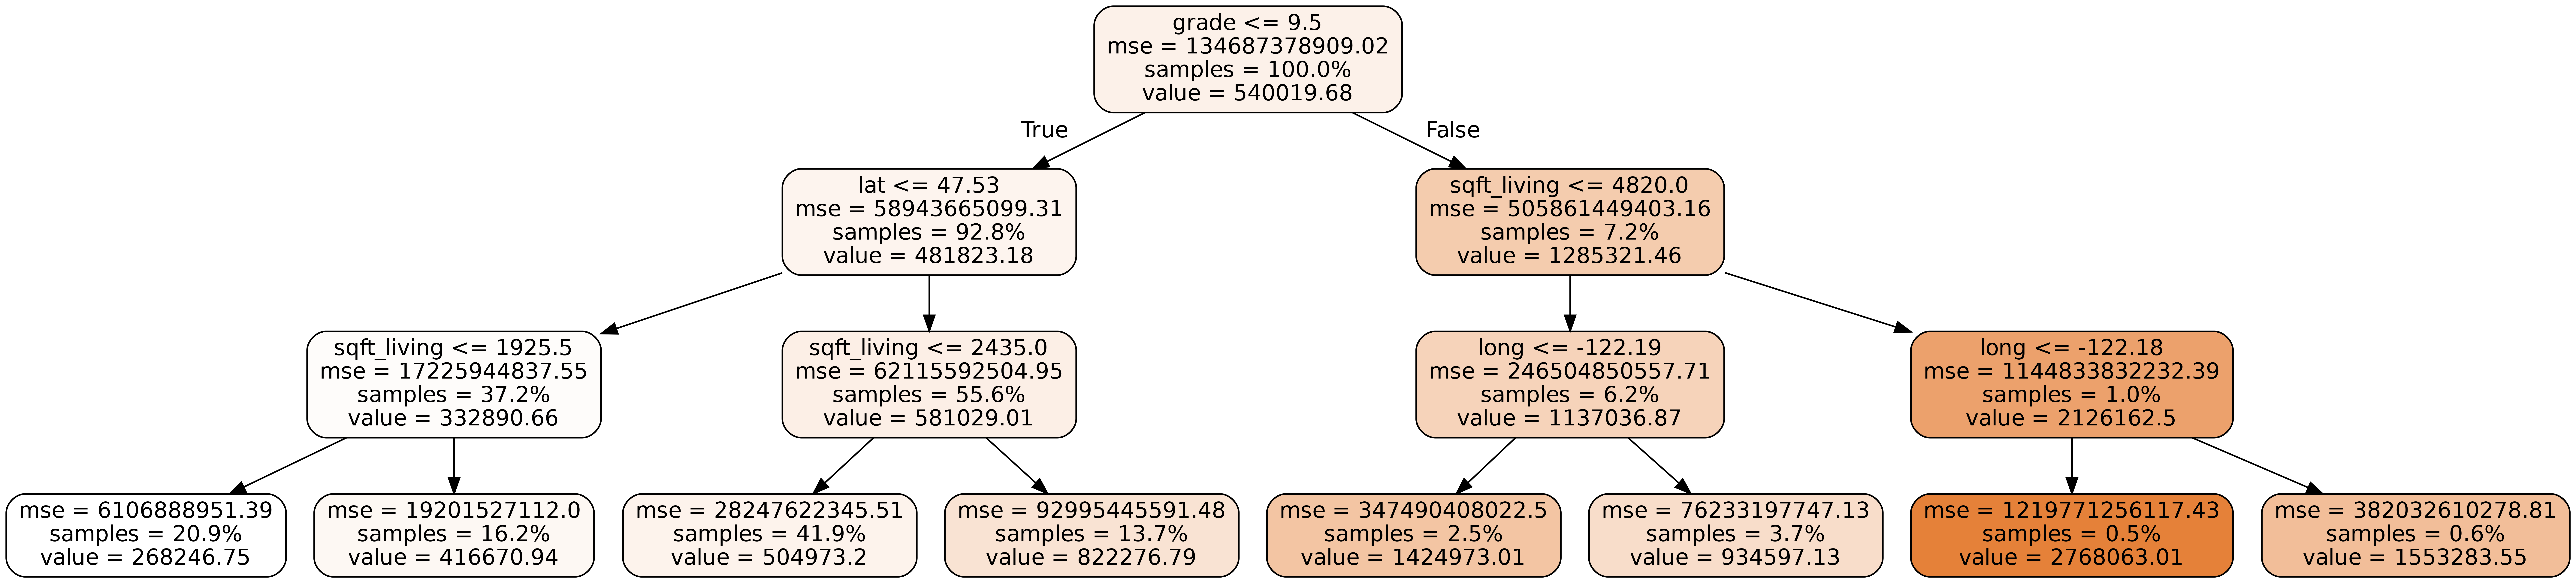

In [8]:
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(model.estimators_[0], out_file='tree.dot', 
                feature_names=df.drop(columns=["price", "date"]).columns,
                rounded=True, proportion=True, 
                precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

We can see that "grade" is in the root of the tree, meaning it's an important feature, as we predicted. Now let's look at feature_importances.

In [9]:
pd.DataFrame({
    "feature": df.drop(columns=["price", "date"]).columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

,feature,importance
2,sqft_living,4.399377e-01
8,grade,3.775861e-01
14,lat,1.456071e-01
5,waterfront,1.356790e-02
15,long,1.222295e-02
11,yr_built,6.496245e-03
9,sqft_above,1.976686e-03
1,bathrooms,1.127161e-03
10,sqft_basement,6.440783e-04
6,view,4.083402e-04


We can see that "grade" and "sqft_living" are important as we prediced, but what surprised me is that "lat" and "lng" are so important. Next step is to plot this heatmap

In [15]:
import plotly.express as px
px.set_mapbox_access_token(open(".key").read())
fig = px.scatter_mapbox(df, lat="lat", lon="long", color="price", color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

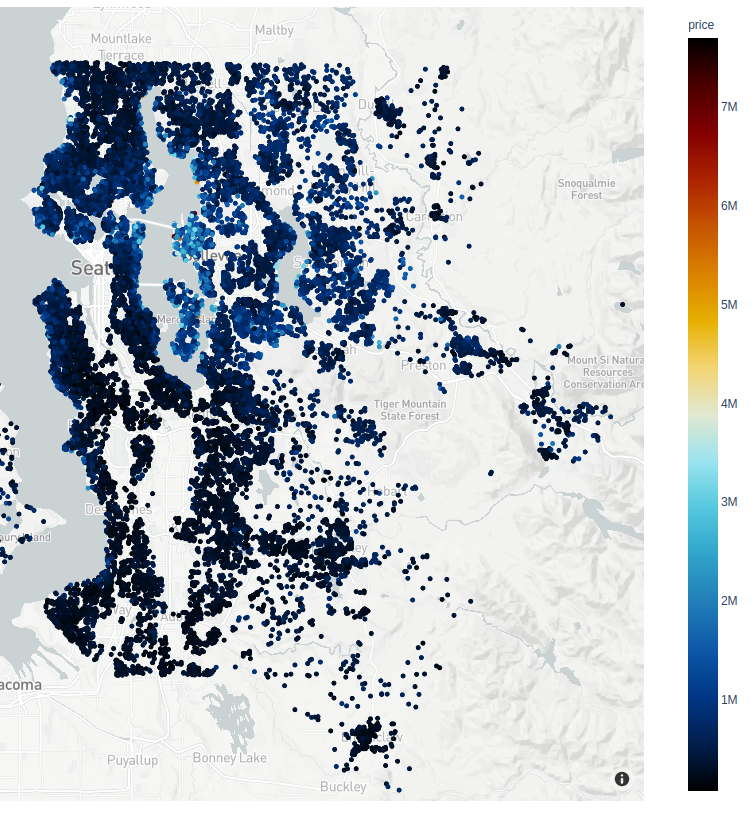

In [16]:
Image(filename='heatmap.png')

As I expected we can spot a place where houses are noticably more expensive